In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

# Leitura de Arquivos

In [2]:
#Economic Freedom World
path_efw = "efw_cc.csv" 

path_bill = "2022_forbes_billionaires.csv"
path_happy = "Happy_2019.csv"
path_HDI = "Human Development Index.csv"
path_suicide = "Suicide_master.csv"

#Arquivos complementares de PIB e População
path_pop = "populationbycountry19802010millions.csv"
path_GDP = "GDP/gdp.csv"
path_GDP_growth = "GDP/gdp_growth.csv"

#Percepção de Corrupção
path_corr = "Corruption/history.csv"

#Melhores Paises para Startups
path_star = "Best Countries/Best Countries for Startups.csv"

#Expectativas de Vida
#path_life = "Life expectancy.csv"

#Gastos Militares em USD
path_militar = "Military Expenditure.csv"

#Salário Mínimo em USD
#path_MW = "MINIMUM_WAGES.csv"

#Unicornios
path_uni = "Unicorns.csv"


In [3]:
data_efw = pd.read_csv(path_efw, sep=',')

data_bill = pd.read_csv(path_bill, sep=',')
data_happy = pd.read_csv(path_happy, sep=',')
data_HDI = pd.read_csv(path_HDI, sep=',')
data_suicide = pd.read_csv(path_suicide, sep=',')

data_pop = pd.read_csv(path_pop, sep=',', index_col = 0)
data_GDP = pd.read_csv(path_GDP, sep=',', index_col = 0)
data_GDP_growth = pd.read_csv(path_GDP_growth, sep=',', index_col = 0)

data_corr = pd.read_csv(path_corr, sep=',')
data_star = pd.read_csv(path_star, sep=',')
#data_life = pd.read_csv(path_life, sep=',')
data_militar = pd.read_csv(path_militar, sep=',')
#data_MW = pd.read_csv(path_MW, sep=',')

data_uni = pd.read_csv(path_uni, sep=',', encoding="utf-8")

# Primeira vizualização e tratamento dos datasets.

In [4]:
#data_bill.country.unique()
#set(data_efw.countries).difference(set(data_corr.Country))
#set(data_corr.Country).difference(set(data_efw.countries))

In [5]:
#Padronizando Nomes de Estudo
#data_efw['countries'] = data_efw['countries'].str.replace('Korea, South', 'South Korea')
data_efw.replace({'countries': {'Cape Verde': 'Cabo Verde',
                                'Korea, South': 'South Korea',
                                'Unit. Arab Em.': 'United Arab Emirates',
                                'Congo, Rep. Of': 'Congo',
                                'Congo, Dem. R.': 'Rep. Dem. Congo'}}, inplace=True)
####

data_bill.drop('Unnamed: 0', axis=1, inplace=True)
data_bill.set_index('rank')
data_bill['networth']=data_bill['networth'].str.replace('$','', regex=True)
data_bill['networth']=data_bill['networth'].str.replace(' B','', regex=True)
data_bill['networth']=data_bill['networth'].apply(pd.to_numeric)

data_bill.replace({'country': {'Eswatini (Swaziland)': 'Swaziland'}}, inplace=True)

####

data_HDI['Country'].astype(str)
data_HDI['Country'] = data_HDI['Country'].str.strip()
data_HDI.replace({'Country': {'Venezuela (Bolivarian Republic of)': 'Venezuela',
                              'Tanzania (United Republic of)': 'Tanzania',
                              'Hong Kong, China (SAR)': 'Hong Kong',
                              'Korea (Republic of)': 'South Korea',
                              'Russian Federation': 'Russia',
                              'Iran (Islamic Republic of)': 'Iran',
                              'Congo (Democratic Republic of the)': 'Rep. Dem. Congo',
                              'Bolivia (Plurinational State of)': 'Bolivia'}}, inplace=True)

####

data_suicide.replace({'country':    {'Czech Republic': 'Czech Rep.',
                                     'Dominica': 'Dominican Rep.',
                                     'Republic of Korea': 'South Korea',
                                     'Russian Federation': 'Russia',
                                     'Slovakia': 'Slovak Rep',
                                     'Trinidad and Tobago': 'Trinidad & Tob.'}}, inplace=True)

####

data_pop.rename(index={'Korea, North': 'North Korea',
                       'Bahamas, The': 'Bahamas',
                       'Brunei': 'Brunei Darussalam',
                       'Cape Verde': 'Cabo Verde',
                       'Central African Republic': 'Central Afr. Rep.',
                       'Czech Republic': 'Czech Rep.',
                       'Dominican Republic': 'Dominican Rep.',
                       'Papua New Guinea': 'Pap. New Guinea',
                       'Slovakia': 'Slovak Rep',
                       'Korea, South': 'South Korea',
                       'Timor-Leste (East Timor)':  'Timor-Leste',
                       'Trinidad and Tobago': 'Trinidad & Tob.',
                       'Yemen':  'Yemen, Rep.'},inplace=True)

####

data_GDP.rename(index={'Bahamas, The':'Bahamas',
                       'Central African Republic': 'Central Afr. Rep.',
                       'Czech Republic': 'Czech Rep.',
                       'Dominican Republic': 'Dominican Rep.',
                       'Egypt, Arab Rep.': 'Egypt',
                       'Hong Kong SAR, China': 'Hong Kong',
                       'Iran, Islamic Rep.': 'Iran',
                       'Lao PDR': 'Laos',
                       'North Macedonia': 'Macedonia',
                       'Papua New Guinea': 'Pap. New Guinea',
                       'Russian Federation': 'Russia',
                       'Slovak Republic': 'Slovak Rep',
                       'Korea, Rep.': 'South Korea',
                       'Syrian Arab Republic': 'Syria',
                       'Trinidad and Tobago': 'Trinidad & Tob.',
                       'Venezuela, RB': 'Venezuela'}, inplace=True)


####
data_GDP_growth.rename(index={'Bahamas, The':'Bahamas',
                       'Central African Republic': 'Central Afr. Rep.',
                       'Czech Republic': 'Czech Rep.',
                       'Dominican Republic': 'Dominican Rep.',
                       'Egypt, Arab Rep.': 'Egypt',
                       'Hong Kong SAR, China': 'Hong Kong',
                       'Iran, Islamic Rep.': 'Iran',
                       'Lao PDR': 'Laos',
                       'North Macedonia': 'Macedonia',
                       'Papua New Guinea': 'Pap. New Guinea',
                       'Russian Federation': 'Russia',
                       'Slovak Republic': 'Slovak Rep',
                       'Korea, Rep.': 'South Korea',
                       'Syrian Arab Republic': 'Syria',
                       'Trinidad and Tobago': 'Trinidad & Tob.',
                       'Venezuela, RB': 'Venezuela'}, inplace=True)
####
                       
data_corr.replace({'Country': {'Brunei': 'Brunei Darussalam',
                               'Cape Verde': 'Cabo Verde',
                               'Central African Republic': 'Central Afr. Rep.',
                               'Czech Republic': 'Czech Rep.',
                               'Dominican Republic': 'Dominican Rep.',
                               'Gambia': 'Gambia, The',
                               'Papua New Guinea': 'Pap. New Guinea',
                               'Slovakia': 'Slovak Rep',
                               'Korea (South)': 'South Korea',
                               'Trinidad and Tobago': 'Trinidad & Tob.',
                               'The United States of America': 'United States',
                               'Yemen': 'Yemen, Rep.'}}, inplace=True)
####

data_uni['Valuation(US$ billions)'] = data_uni['Valuation(US$ billions)'].str.replace('+','')
data_uni['Valuation(US$ billions)'] = data_uni['Valuation(US$ billions)'].astype(float)
data_uni['Country/countries'] = data_uni['Country/countries'].astype(str)
data_uni['Country/countries'] = data_uni['Country/countries'].apply(lambda x: str(x).replace(u'\xa0', u''))
data_uni.replace({'Country/countries': {'US': 'United States',
                             'US / Ireland': 'United States',
                             'UK': 'United Kingdom',
                             'UK / UAE': 'United Kingdom',
                             'Ukraine[39]/United States[40]': 'Ukraine',
                             'China / Hong Kong': 'China',
                             'Hong Kong / China': 'Hong Kong',
                             'Portugal / US': 'Portugal',
                             'US[67]': 'United States',
                             'India / US': 'India',
                             'Australia / Hong Kong': 'Australia',
                             'China / US': 'China',
                             'UK / US': 'United Kingdom',
                             'France / US': 'France',
                             'Israel / US': 'Israel',
                             'Brazil / US': 'Brazil',
                             'US / Israel': 'United States',
                             'Argentina / US': 'Argentina',
                             'Portugal / US [308]': 'Portugal',
                             'Senegal / US': 'Senegal',
                             'Israel /  US': 'Israel',
                             'Nigeria / US': 'Nigeria',
                             'US[362]': 'United States',
                             'USA': 'United States',
                             'Spain / US': 'Spain',
                             'Germany / Russia': 'Germany',
                             'Singapore / Israel': 'Singapore',
                             'US, UK and Europe': 'United States',
                             'Singapore / Switzerland': 'Singapore',
                             'UAE': 'United Arab Emirates',
                             'Canada / USA': 'Canada',
                             'India/ US': 'India',
                             'Croatia / UK': 'Croatia',
                             'India / Singapore': 'India',
                             'Armenia / US': 'Armenia',
                             'Estonia / US': 'Estonia'}}, inplace=True)
data_uni.columns = ['Company', 'Valuation(US$ billions)', 'Valuation date', 'Industry',
       'country', 'Founder(s)']

In [22]:
datas = [data_efw,
         data_bill, 
         data_happy, 
         data_HDI, 
         data_suicide, 
         data_pop, 
         data_GDP,
         data_corr, 
         data_star, 
         data_militar,
         data_GDP_growth,
         data_uni]
         #data_MW]

In [23]:
#Escolha dos Países a Serem Analizados
countries = np.array(list(set(data_efw.countries).intersection(#set(data_bill.country), 
                                                               set(data_happy['Country or region']), 
                                                               set(data_HDI.Country), 
                                                               set(data_suicide.country), 
                                                               set(data_pop.index), 
                                                               set(data_GDP.index),
                                                               set(data_corr.Country), 
                                                               set(data_star.country), 
                                                               set(data_militar.Name),
                                                               set(data_GDP_growth.index))))

# Criação dos Dataframes de Estudo.

In [24]:
DF = []
DF_std2 = pd.DataFrame()

for x in range(len(countries)): 
    pais = countries[x]

    # Parcela A
    std = datas[0][datas[0]['countries'] == pais].sort_values(by='year')
    std = std.reset_index()
    a = std.drop(columns=['index','ISO_code']) #, inplace=True)

    # Parcela B e C
    b = datas[1][datas[1]['country'] == pais].groupby(['country']).name.count()
    c = datas[1][datas[1]['country'] == pais].groupby(['country']).networth.sum()

    # Parcela D
    d = datas[2][datas[2]['Country or region'] == pais]

    # Parcela E
    std = datas[3][datas[3]['Country'] == pais].iloc[:,2:].transpose()
    std = std.reset_index()
    std.columns = ['year', 'HDI']
    e = std
    e['year'] = e.year.astype(int)


    # Parcela F
    std = datas[4][datas[4]['country'] == pais]
    std = std.drop(columns=['country', 'sex', 'age', 'country-year', 'suicides/100k pop',
                            'population', 'gdp_per_capita ($)', 'generation'])#, inplace=True)

    #std.iloc[:,4].unique()

    std1 = std.iloc[:,:2].groupby(['year']).sum()
    f0 = std1.reset_index()

    f1 = pd.DataFrame(std.groupby(['year'])['HDI for year'].max())
    f2 = pd.DataFrame(std.groupby(['year'])[' gdp_for_year ($) '].max())
    ff = pd.concat([f1, f2], axis=1)
    ff = ff.reset_index()

    f = pd.concat([f0, ff], axis = 1)
    f.columns = ['year', 'suicides_no', 'year_2', 'HDI_2', 'GDP_2']

    f['GDP_2'] = f['GDP_2'].str.replace(',','')
    f['GDP_2'] = f.GDP_2.astype(float)
    f.drop(columns=['year_2'], inplace=True)

    # Parcela G

    std = pd.DataFrame(datas[5].loc[pais])
    std = std.reset_index()
    std.columns = ['year', 'Population']
    g = std
    g['year'] = g.year.astype(int)

    # Parcela H

    std = pd.DataFrame(datas[6].loc[pais][1:])
    std = std.reset_index()
    std.columns = ['year', 'GDP'] #PIB
    h = std.iloc[:-1]
    h['year'] = h.year.astype(int)
    h['GDP'] = h.GDP.astype(float)

    # Parcela I
    
    std = datas[7][datas[7]['Country'] == pais].iloc[:,4:]
    std.columns = ['2016', '2015', '2014', '2013', '2012']
    std = std.transpose()
    std = std.reset_index()
    std.columns = ['year', 'CPI']
    i = std
    i['year'] = i.year.astype(int)

    # Parcela J

    std = datas[8][datas[8]['country'] == pais].iloc[:,[0,3]].transpose()
    std.columns = ['Startups_Score_2020']
    j = std

    # Parcela K

    std = datas[9][datas[9]['Name'] == pais]
    std = std.iloc[:,4:].transpose()
    std = std.reset_index()
    std.columns = ['year', 'Military_Expenditure_USD']
    k = std
    k['year'] = k.year.astype(int)
    
    # Parcela L

    std = pd.DataFrame(datas[10].loc[pais][1:])
    std = std.reset_index()
    std.columns = ['year', 'GDP_growth'] #Crescimento do PIB
    l = std.iloc[:-1]
    l['year'] = l.year.astype(int)
    l['GDP_growth'] = l.GDP_growth.astype(float)
    
    # Parcela M e N
    
    m = datas[11][datas[11]['country'] == pais].groupby(['country']).Company.count()
    n = datas[11][datas[11]['country'] == pais].groupby(['country'])['Valuation(US$ billions)'].sum()
    
    # 0 3 4 5 6 9 - DF por pais
    # Letras - a e f g h k l

    # 1 2 7 8 - DF todos os paises
    # Letras - b c d i j

    DF2 =  pd.merge(b, c, how = 'outer', on = 'country')
    DF2 =  pd.merge(DF2, m, how = 'outer', on = 'country')
    DF2 =  pd.merge(DF2, n, how = 'outer', on = 'country')
    DF2 = DF2.reset_index()
    d = d.rename(columns={'Country or region': 'country'})
    DF2 =  pd.merge(DF2, d, how = 'outer', on = 'country')
    DF2['Corru_Perc_Index'] = i.iloc[0,1]
    DF2['Startups_Ranking_2020'] = j.iloc[0,0]
    DF2['Startups_Score_2020'] = j.iloc[1,0]
    
    DF_std2 = pd.concat([DF_std2, DF2])
    
    ### Unindo os Dataframes em um Único.

    df_std = pd.merge(a, e, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, f, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, g, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, h, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, k, how = 'outer', on = 'year')
    df_std = pd.merge(df_std, l, how = 'outer', on = 'year')
    df_std = df_std.sort_values(by='year').reset_index(drop=True)
    df_std['HDI_year'] = df_std.loc[:,['HDI','HDI_2']].max(skipna=True, axis=1)
    df_std['GDP_year'] = df_std.loc[:,['GDP','GDP_2']].max(skipna=True, axis=1)

    # Preenchendo os Valores da População Utilizando regressão linear.

    df_inter = df_std.interpolate(method='linear', limit_direction='both', axis=0)
    df = df_inter.loc[:,['year','Population']].dropna(how='any')
    df['Population'] = df['Population'].str.replace('--','0')
    
    X = pd.DataFrame(df.year)
    y = df.Population

    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state = 1)

    model = LinearRegression(fit_intercept = True)
    model.fit(Xtrain, ytrain)
    ypred = model.predict(pd.DataFrame(df_inter.year))

    df_inter['Population_year'] = ypred
 
    # Preenchendo NaN dos paíes
    values = {"countries": pais}
    df_inter = df_inter.fillna(value=values)
    
    # Removendo colunas utilizadas 

    df_inter.drop(columns=['HDI','HDI_2','GDP','GDP_2', 'Population'], inplace=True)

    DF.append(df_inter)

In [25]:
### Unindo todos os DF em um único Parte 1.
DF_std = pd.DataFrame()
for x in range(len(countries)):
    DF_std = pd.concat([DF_std, DF[x]])
    
DF_std['GDP_Per_capita'] = DF_std['GDP_year'] / DF_std['Population_year']
DF_std = DF_std.sort_values(by=['countries', 'year'])
DF_std = DF_std.reset_index(drop=True)

### Unindo todos os DF em um único Parte 2.

DF_std2.columns = ['Country', 'No_billionaires', 'Networth', 'No_unicorns', 'Valuation_US$_billions',
                   'Happy_rank', 'Happy_score', 'GDP_per_capita', 'Social_support',
                   'Healthy_life_expectancy', 'Freedom_to_make_life_choices', 'Generosity',
                   'Perceptions_of_corruption', 'Corru_Perc_Index',
                   'Startups_Ranking_2020', 'Startups_Score_2020']

DF_std2.drop(columns=['GDP_per_capita'], inplace=True)
DF_std2 = DF_std2.sort_values(by='Country')
DF_std2 = DF_std2.reset_index(drop=True)


DF_std.columns = ['Year', 'Countries', 'Economic_Freedom', 'F_rank', 'Quartile',
       '1a_government_consumption', '1b_transfers', '1c_gov_enterprises',
       '1d_top_marg_tax_rate', '1.0_size_government', '2a_judicial_independence',
       '2b_impartial_courts', '2c_protection_property_rights',
       '2d_military_interference', '2e_integrity_legal_system',
       '2f_legal_enforcement_contracts', '2g_restrictions_sale_real_property',
       '2h_reliability_police', '2i_business_costs_crime',
       '2j_gender_adjustment', '2.0_property_rights', '3a_money_growth',
       '3b_std_inflation', '3c_inflation', '3d_freedom_own_foreign_currency',
       '3.0_sound_money', '4a_tariffs', '4b_regulatory_trade_barriers',
       '4c_black_market', '4d_control_movement_capital_ppl', '4.0_trade',
       '5a_credit_market_reg', '5b_labor_market_reg', '5c_business_reg',
       '5.0_regulation', 'Suicides_No', 'Military_Expenditure_USD', 'GDP_growth',
       'HDI_year', 'GDP_year', 'Population_year', 'GDP_Per_capita']

# Unindo os 2 DF no DF_std2 criando novas colunas com os índices do DF_std

lista = list(DF_std.columns[2:42])
for r in lista:
    item = r
    name = r[:3]
    DF_std2[name +'_'+'1980_2020'] = list(DF_std[DF_std['Year'] >= 1980].groupby(['Countries'])[r].mean().values)
    DF_std2[name +'_'+'2000_2020'] = list(DF_std[DF_std['Year'] >= 2000].groupby(['Countries'])[r].mean().values)
    DF_std2[name +'_'+'2010_2020'] = list(DF_std[DF_std['Year'] >= 2010].groupby(['Countries'])[r].mean().values)

DF_std2.fillna(0, inplace=True)


# Estudos Primilinares Após Limpeza e União de Dados

In [11]:
DF_std.Countries.unique()

array(['Albania', 'Argentina', 'Armenia', 'Australia', 'Austria',
       'Azerbaijan', 'Bahrain', 'Belarus', 'Belgium',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Chile',
       'Colombia', 'Costa Rica', 'Croatia', 'Cyprus', 'Denmark',
       'Ecuador', 'Estonia', 'Finland', 'France', 'Georgia', 'Germany',
       'Greece', 'Hungary', 'Iceland', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Kazakhstan', 'Kuwait', 'Latvia', 'Lithuania',
       'Luxembourg', 'Malta', 'Mauritius', 'Mexico', 'Mongolia',
       'New Zealand', 'Norway', 'Panama', 'Paraguay', 'Philippines',
       'Poland', 'Portugal', 'Qatar', 'Romania', 'Serbia', 'Singapore',
       'Slovenia', 'South Africa', 'South Korea', 'Spain', 'Sri Lanka',
       'Sweden', 'Switzerland', 'Thailand', 'Turkey', 'Ukraine',
       'United Arab Emirates', 'United Kingdom', 'United States',
       'Uruguay'], dtype=object)

<AxesSubplot:xlabel='Year', ylabel='3a_money_growth'>

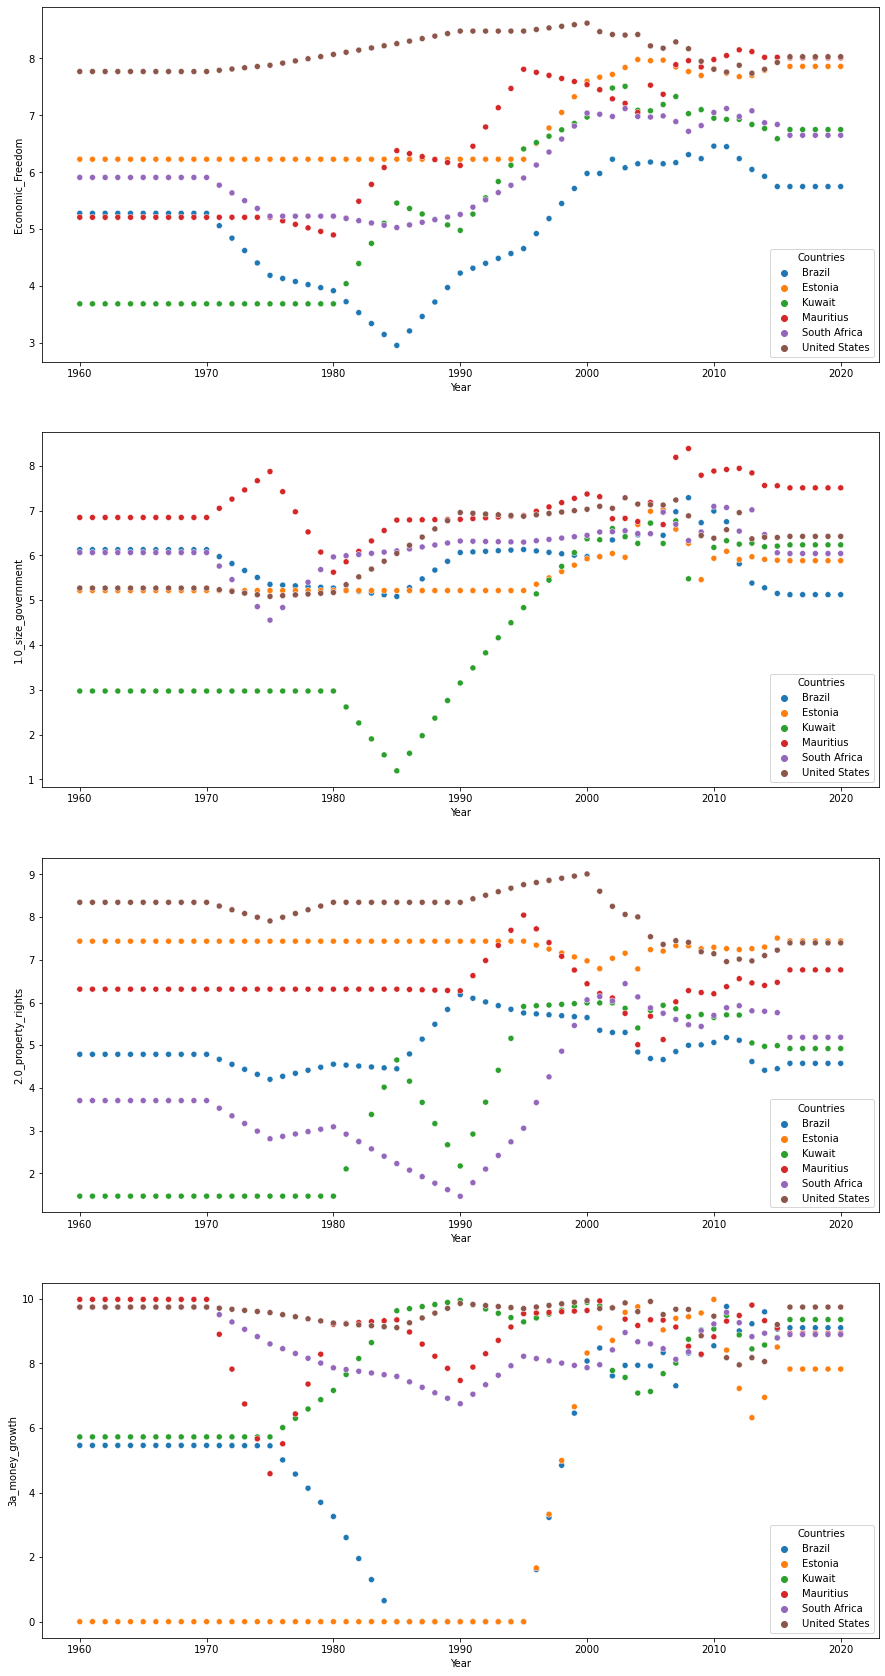

In [26]:
fig, axes = plt.subplots(4, 1, sharex=False, figsize=(15,30))

lista_p= ['Brazil', 'Kuwait', 'Estonia', 'United States', 'Mauritius', 'South Africa']
lock = DF_std.Countries.isin(lista_p)
data = DF_std.loc[lock]
sns.scatterplot(ax=axes[0], data = data, x = data['Year'] , y = data['Economic_Freedom'], hue= data.Countries)
sns.scatterplot(ax=axes[1], data = data, x = data['Year'] , y = data['1.0_size_government'], hue= data.Countries)
sns.scatterplot(ax=axes[2], data = data, x = data['Year'] , y = data['2.0_property_rights'], hue= data.Countries)
sns.scatterplot(ax=axes[3], data = data, x = data['Year'] , y = data['3a_money_growth'], hue= data.Countries)


In [48]:
DF_std2.describe()

,No_billionaires,Networth,No_unicorns,Valuation_US$_billions,Happy_rank,Happy_score,Social_support,Healthy_life_expectancy,Freedom_to_make_life_choices,Generosity,...,Mil_2010_2020,GDP_1980_2020,GDP_2000_2020,GDP_2010_2020,HDI_1980_2020,HDI_2000_2020,HDI_2010_2020,Pop_1980_2020,Pop_2000_2020,Pop_2010_2020
count,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000,...,6.700000e+01,6.700000e+01,6.700000e+01,6.700000e+01,67.000000,67.000000,67.000000,67.000000,67.000000,67.000000
mean,24.059701,129.725373,6.716418,27.650149,46.686567,6.180030,1.400746,0.901701,0.436358,0.174776,...,1.810059e+10,1.806347e+10,2.477994e+10,2.947791e+10,0.767964,0.812839,0.833612,25.903454,29.514123,31.319457
std,89.036914,576.373561,26.726338,137.034188,33.500886,0.851705,0.163541,0.122033,0.130945,0.092364,...,7.895002e+10,1.763277e+10,2.530537e+10,3.186784e+10,0.077610,0.077455,0.072777,45.471093,50.898371,53.745883
min,0.000000,0.000000,0.000000,0.000000,1.000000,4.332000,0.666000,0.469000,0.067000,0.000000,...,0.000000e+00,-7.305422e+08,1.842170e+09,2.061683e+09,0.629415,0.653667,0.683091,0.281886,0.309148,0.322780
25%,0.000000,0.000000,0.000000,0.000000,18.500000,5.718000,1.337000,0.821500,0.354000,0.101000,...,5.762628e+08,4.318550e+09,6.177003e+09,7.739586e+09,0.703134,0.742381,0.774364,3.191092,3.991620,4.414282
50%,3.000000,11.900000,1.000000,1.000000,43.000000,6.125000,1.442000,0.881000,0.471000,0.153000,...,3.194693e+09,1.026779e+10,1.146447e+10,1.461913e+10,0.770293,0.816667,0.836818,7.305197,7.744868,7.964703
75%,21.000000,78.500000,3.000000,8.615000,64.500000,6.907500,1.504500,1.004000,0.545500,0.258000,...,8.282402e+09,3.059323e+10,4.138480e+10,4.614340e+10,0.837366,0.885524,0.900045,37.785821,40.301842,41.559853
max,719.000000,4685.100000,215.000000,1111.210000,133.000000,7.769000,1.624000,1.141000,0.603000,0.375000,...,6.448182e+11,7.258210e+10,1.237641e+11,1.769467e+11,0.903073,0.939095,0.948182,280.766679,309.300579,323.567529


In [52]:
list(DF_std2.columns)

['Country',
 'No_billionaires',
 'Networth',
 'No_unicorns',
 'Valuation_US$_billions',
 'Happy_rank',
 'Happy_score',
 'Social_support',
 'Healthy_life_expectancy',
 'Freedom_to_make_life_choices',
 'Generosity',
 'Perceptions_of_corruption',
 'Corru_Perc_Index',
 'Startups_Ranking_2020',
 'Startups_Score_2020',
 'Eco_1980_2020',
 'Eco_2000_2020',
 'Eco_2010_2020',
 'F_r_1980_2020',
 'F_r_2000_2020',
 'F_r_2010_2020',
 'Qua_1980_2020',
 'Qua_2000_2020',
 'Qua_2010_2020',
 '1a__1980_2020',
 '1a__2000_2020',
 '1a__2010_2020',
 '1b__1980_2020',
 '1b__2000_2020',
 '1b__2010_2020',
 '1c__1980_2020',
 '1c__2000_2020',
 '1c__2010_2020',
 '1d__1980_2020',
 '1d__2000_2020',
 '1d__2010_2020',
 '1.0_1980_2020',
 '1.0_2000_2020',
 '1.0_2010_2020',
 '2a__1980_2020',
 '2a__2000_2020',
 '2a__2010_2020',
 '2b__1980_2020',
 '2b__2000_2020',
 '2b__2010_2020',
 '2c__1980_2020',
 '2c__2000_2020',
 '2c__2010_2020',
 '2d__1980_2020',
 '2d__2000_2020',
 '2d__2010_2020',
 '2e__1980_2020',
 '2e__2000_2020',
 

In [86]:
list(DF_std2.iloc[:,1:].columns)
feature_cols = list(DF_std2.iloc[:,1:].columns)

feature_cols.remove('Startups_Ranking_2020')
feature_cols.remove('Startups_Score_2020')
feature_cols

['No_billionaires',
 'Networth',
 'No_unicorns',
 'Valuation_US$_billions',
 'Happy_rank',
 'Happy_score',
 'Social_support',
 'Healthy_life_expectancy',
 'Freedom_to_make_life_choices',
 'Generosity',
 'Perceptions_of_corruption',
 'Corru_Perc_Index',
 'Eco_1980_2020',
 'Eco_2000_2020',
 'Eco_2010_2020',
 'F_r_1980_2020',
 'F_r_2000_2020',
 'F_r_2010_2020',
 'Qua_1980_2020',
 'Qua_2000_2020',
 'Qua_2010_2020',
 '1a__1980_2020',
 '1a__2000_2020',
 '1a__2010_2020',
 '1b__1980_2020',
 '1b__2000_2020',
 '1b__2010_2020',
 '1c__1980_2020',
 '1c__2000_2020',
 '1c__2010_2020',
 '1d__1980_2020',
 '1d__2000_2020',
 '1d__2010_2020',
 '1.0_1980_2020',
 '1.0_2000_2020',
 '1.0_2010_2020',
 '2a__1980_2020',
 '2a__2000_2020',
 '2a__2010_2020',
 '2b__1980_2020',
 '2b__2000_2020',
 '2b__2010_2020',
 '2c__1980_2020',
 '2c__2000_2020',
 '2c__2010_2020',
 '2d__1980_2020',
 '2d__2000_2020',
 '2d__2010_2020',
 '2e__1980_2020',
 '2e__2000_2020',
 '2e__2010_2020',
 '2f__1980_2020',
 '2f__2000_2020',
 '2f__201

# Aplicando Modelo de ML

In [113]:
# Linear Regression

feature_cols = list(DF_std2.iloc[:,1:].columns)
feature_cols.remove('Startups_Ranking_2020')
feature_cols.remove('Startups_Score_2020')

X = DF_std2[feature_cols].copy()
y = DF_std2.Startups_Score_2020

#normalizando os dados
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = SEED)

model = LinearRegression(fit_intercept = True)

model.fit(Xtrain, ytrain)

test_sklearn = np.array(Xtest)
model.predict(test_sklearn)

ypred = model.predict(Xtest)


print ('MAE:', mean_absolute_error(ytest, ypred).round(2))
print ('MSE:', mean_squared_error(ytest, ypred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(ytest, ypred)).round(2))
print ('R2:', r2_score(ytest, ypred).round(2))

MAE: 30.33
MSE: 1499.84
RMSE: 38.73
R2: -1.8


<AxesSubplot:xlabel='Startups_Ranking_2020', ylabel='Density'>

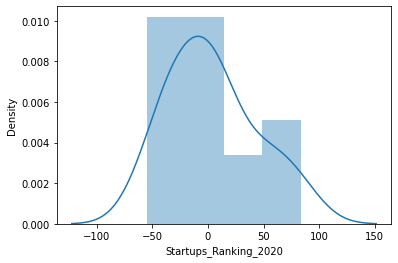

In [115]:
sns.distplot(ytest - ypred)

(<Figure size 1080x360 with 1 Axes>,
 <AxesSubplot:title={'center':'Comparação de Valores'}, xlabel='Country Index', ylabel='Startups_Score_2020'>)

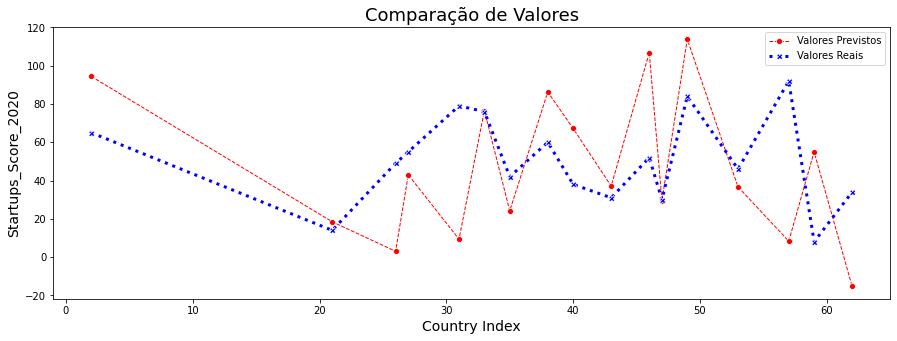

In [118]:
ax = plt.subplots(figsize=(15,5))

sns.lineplot(x=Xtest.index, y=ypred,
             label="Valores Previstos",
             color='red', marker='o',
             linestyle='--', linewidth=1)

sns.lineplot(x=Xtest.index,y=ytest,
             label="Valores Reais",
             color='blue', marker='X',
             linestyle=':', linewidth=3)

plt.legend(loc="best")
plt.title('Comparação de Valores', fontsize=18)
plt.xlabel('Country Index', fontsize=14)
plt.ylabel('Startups_Score_2020', fontsize=14)
plt.xticks(rotation=0)
ax